**DIO Cognizant Cloud Data Engineer Bootcamp - Projeto 1 **
## Gráficos do PIB do Brasil de 2010 e 2018

PIB e População do Brasil por UF em 2010: http://www.servicos.blog.br/listas/lista-de-estados-brasileiros-com-populacao-e-pib-em-excel/

PIB do Brasil por UF em 2018: https://www.ibge.gov.br/explica/pib.php
(Estimativas_de_Populacao/Estimativas_2018/estimativa_dou_2018_20181019.xls)


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import requests

In [32]:
#dataframe
#df = pd.read_csv('/content/drive/MyDrive/DIO_analisedados_python/poppib_2010_2018_csv.csv', error_bad_lines=False, sep=';')

url = 'https://raw.githubusercontent.com/sergioinoue/DIO_DataEngineer/main/poppib_2010_2018_csv.csv'
cont = requests.get(url).content
df = pd.read_csv(io.StringIO(cont.decode('utf-8')), error_bad_lines=False, sep=';')

#df = pd.read_csv('/content/poppib_2010_2018_csv.csv', error_bad_lines=False, sep=';')
df.tail()

,Ano,UF,UF_desc,Regiao,Pop,PIB_milhao
49,2018,RR,Roraima,Norte,576568,13370
50,2018,SC,Santa Catarina,Sul,7075494,298227
51,2018,SP,São Paulo,Sudeste,45538936,2210562
52,2018,SE,Sergipe,Nordeste,2278308,42018
53,2018,TO,Tocantins,Norte,1555229,35666


In [33]:
#cria dataframe agrupado por Ano, com somatoria das colunas PIB_milhao, Pop
df_ano_pib_pop = df.groupby(['Ano'], as_index=False).agg({'PIB_milhao': ['sum'], 'Pop': ['sum']})

#renomear as colunas agregadas
df_ano_pib_pop.columns = ['Ano','Pib','Pop']

df_ano_pib_pop

,Ano,Pib,Pop
0,2010,3770086,190732694
1,2018,7004141,208494900


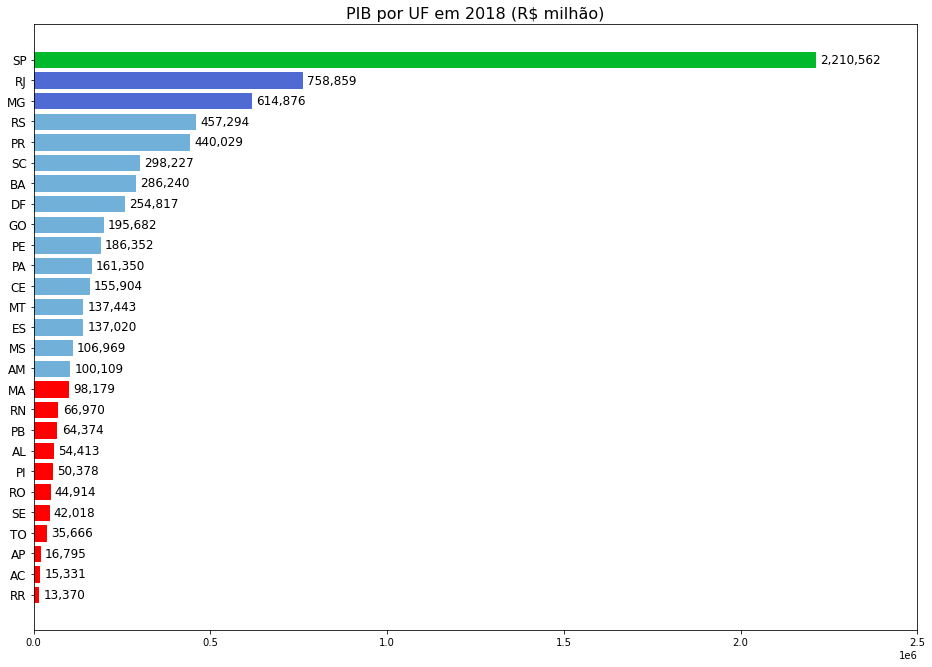

In [34]:
#PIB por UF em 2018 - gráfico de barras

fig, ax = plt.subplots()
fig.set_size_inches(13,9)
fig.tight_layout()

df_x = df[df['Ano']==2018].groupby(['UF'], as_index=False).agg({'PIB_milhao': ['sum']})
df_x.columns = ['UF','Pib']
df_x = df_x.sort_values('Pib',ascending=True)

#df[df['Ano']==2018].groupby(['UF'])['PIB_milhao'].sum().sort_values(ascending=True).plot(kind='barh', ax=ax, title='PIB por UF em 2018', legend=False, color='#3EB595');

plt.title('PIB por UF em 2018 (R$ milhão)', fontsize=16)
plt.xlim([0,2500000])
bars = ax.barh(df_x['UF'], df_x['Pib'],0.75,color='#3EB595')

for bar in bars:
  width = bar.get_width()
  label_y_pos = bar.get_y() + bar.get_height() / 2
  ax.text((width + 15000), label_y_pos, s=f'{width:,d}', va='center', fontsize=12)
#  ax.text(width, label_y_pos, s=f'{width}', va='center')
  if (width > 1000000):
    bar.set_color('#00BA2B')
  elif (width > 500000 and width <= 1000000):
    bar.set_color('#506AD4')
  elif (width > 100000 and width <= 500000):
    bar.set_color('#71B1D9')
  else:
    bar.set_color('red')
    #bar.set_color('#AC1923')

for tick in ax.yaxis.get_major_ticks():
  tick.label.set_fontsize(12)


In [35]:
#dataframe por regiao
df_regiao_2018 = df[df['Ano']==2018].groupby('Regiao').sum()

#drop coluna Ano
df_regiao_2018.drop(['Ano'], axis=1,inplace=True)

#renomear as colunas
df_regiao_2018.columns = ['Pop','Pib']

df_regiao_2018.reset_index(inplace=True)

#classificar o dataframe pelo Pib
df_regiao_2018.sort_values(by=['Pib'], ascending=False, inplace=True)


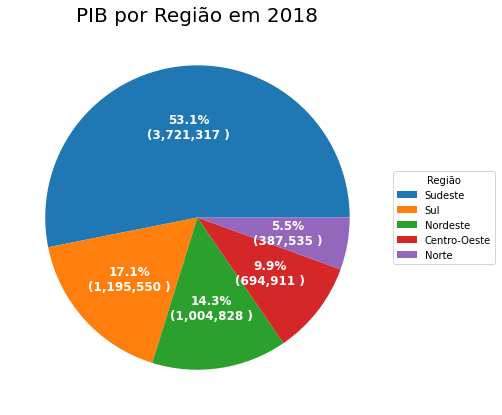

In [36]:
#PIB por Região em 2018 - pie chart

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))

data = df_regiao_2018['Pib']
grupo = df_regiao_2018['Regiao']


def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:,d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, grupo, title="Região", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

font1 = {'color':'black','size':20}
ax.set_title("PIB por Região em 2018", font1)

plt.show()

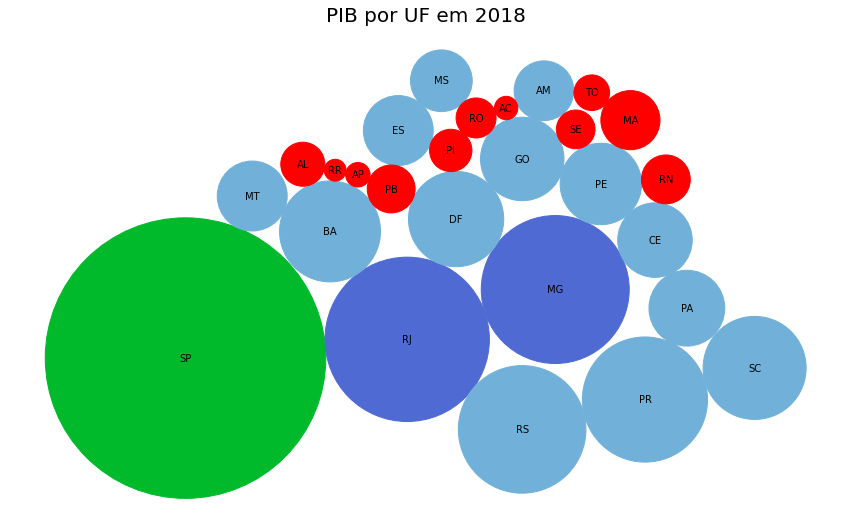

In [37]:
#PIB por UF em 2018 - Packed-bubble chart

df_x = df[df['Ano']==2018].groupby(['UF'], as_index=False).agg({'PIB_milhao': ['sum']})
df_x.columns = ['UF','Pib']
df_x = df_x.sort_values('Pib',ascending=False)

regiao_pib_dados = {
    'regiao': df_x['UF'].values.tolist(),
    'pib': df_x['Pib'].values.tolist(),
    'color': ['#00BA2B', '#506AD4', '#506AD4', '#71B1D9'
              , '#71B1D9', '#71B1D9', '#71B1D9', '#71B1D9', '#71B1D9', '#71B1D9', '#71B1D9', '#71B1D9', '#71B1D9', '#71B1D9', '#71B1D9', '#71B1D9'
              , 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red' ]
}

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')


bubble_chart = BubbleChart(area=regiao_pib_dados['pib'],
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, regiao_pib_dados['regiao'], regiao_pib_dados['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('PIB por UF em 2018')

fig.set_size_inches(15,12)

font1 = {'color':'black','size':20}
ax.set_title("PIB por UF em 2018", font1)

plt.show()


,Ano,Pib,Pop
1,2018,7004141,208494900
0,2010,3770086,190732694


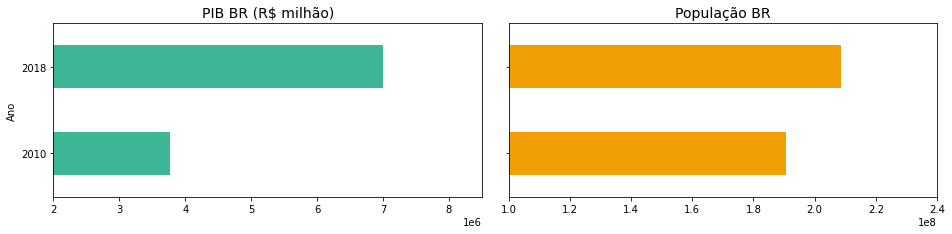

In [38]:
#Total do PIB e População, comparativo 2010/2018 - gráfico de barras

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(13,3)

#para tirar o label 2010,2018 das barras do grafico População
ax1.label_outer()
ax2.label_outer()
fig.tight_layout()
df_ano_pib_pop.plot(kind='barh', y='Pib', x='Ano', ax=ax1, title='PIB', legend=False, color='#3EB595', xlim=[2000000,8500000])
#tirando o label do eixo Ano, com o parametro xlabel=''
df_ano_pib_pop.plot(kind='barh', y='Pop', x='Ano', ax=ax2, title='População', legend=False, color='#F29F05', xlim=[100000000,240000000], xlabel='');

ax1.set_title('PIB BR (R$ milhão)', fontsize=14)
ax2.set_title('População BR', fontsize=14)

df_ano_pib_pop.sort_index(ascending=False)

#plt.show()